# "Home Grown" Decision Tree in PySpark

This is our implementation of a Decision Tree in Spark, based on the [PLANET algorithm](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/36296.pdf)

In [1]:
from operator import itemgetter

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

from tree import DecisionTreeBinaryClassifier

In [2]:
# start Spark Session
from pyspark.sql import SparkSession

app_name = "w261_tree_scratch"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Toy Example - Synthesized Data

First, I'll create fake data using a couple calls to `np.random.multivariate_normal` and assigning labels to them. We'll just see if we can reasonably classify some 2D data.

In [4]:
# how many examples in each class
n = 30000

pos = np.random.multivariate_normal((4, 0), ((1., -0.5), (-0.5, 1.)), n)
pos = np.hstack((pos, np.ones((n, 1)))) # add the labels
neg = np.random.multivariate_normal((5.5, 1.5), ((1., -0.5), (-0.5, 1.)), n)
neg = np.hstack((neg, np.zeros((n, 1)))) # add the labels

# put everything together and shuffle
data = np.vstack((pos, neg))
np.random.shuffle(data)

toyRDD = sc.parallelize(data).map(lambda row: (row[-1], row[:-1])).cache()

In [5]:
# instantiate the model and train it
tree = DecisionTreeBinaryClassifier(2, {}, max_depth=6)
%time tree.train(toyRDD)
print(tree.tree_root)

CPU times: user 250 ms, sys: 20 ms, total: 270 ms
Wall time: 17.7 s
TreeNode(id=0, n=60000, gini_impurity=0.5, probability=0.5, split_feat=0, split_val=16)
├──TreeNode(id=1, n=31857, gini_impurity=0.36569041471896235, probability=0.759142417679003, split_feat=1, split_val=22)
│  ├──TreeNode(id=3, n=24278, gini_impurity=0.1472525888630789, probability=0.9199686959387099, split_feat=1, split_val=16)
│  │  ├──TreeNode(id=7, n=19295, gini_impurity=0.06258821971515882, probability=0.9676600155480695, split_feat=1, split_val=12)
│  │  │  ├──TreeNode(id=15, n=15051, gini_impurity=0.02983803642461158, probability=0.9848515048833965, split_feat=0, split_val=12)
│  │  │  │  ├──TreeNode(id=31, n=11650, gini_impurity=0.013470264694505296, probability=0.9932188841201717, split_feat=0, split_val=8)
│  │  │  │  │  ├──Leaf(id=63, n=7932, gini_impurity=0.0035237745750631433, probability=0.9982349974785678)
│  │  │  │  │  └──Leaf(id=64, n=3718, gini_impurity=0.03435375812998198, probability=0.9825174825

### Evaluation

Now that it's trained, we'll check the training accuracy and some other metrics to see how we did.

In [6]:
probs = tree.predict(toyRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == data[:, -1])
print(accuracy)
print(confusion_matrix(data[:, -1], predictions))
print(classification_report(data[:, -1], predictions))

0.9308833333333333
[[28027  1973]
 [ 2174 27826]]
             precision    recall  f1-score   support

        0.0       0.93      0.93      0.93     30000
        1.0       0.93      0.93      0.93     30000

avg / total       0.93      0.93      0.93     60000



### Plots

Finally, we'll plot the bins and the decision boundary because it's cool.

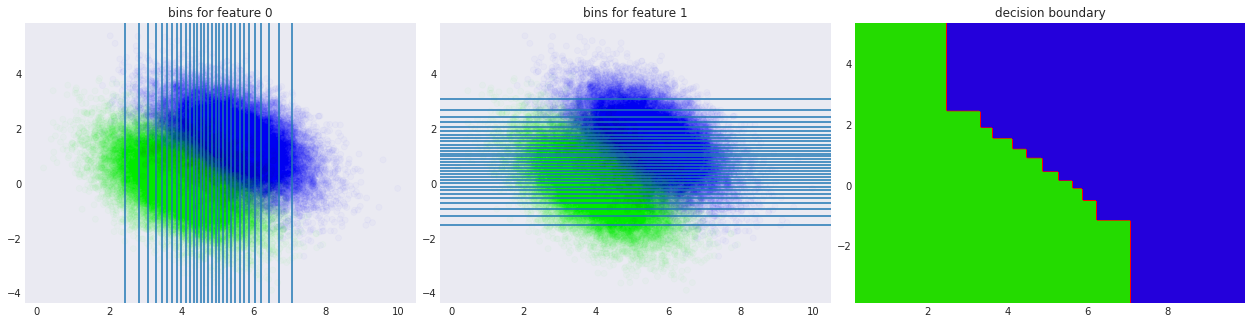

In [7]:
colors = np.array([[0., 0., 1., 0.02] if label == 0 else [0., 1., 0., 0.02] for label in data[:, -1]])

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[0]:
    plt.axvline(x=i)
plt.gca().set_title("bins for feature 0")

plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=colors)
for i in tree.continuous_bins[1]:
    plt.axhline(y=i)
plt.gca().set_title("bins for feature 1")
    
plt.subplot(1, 3, 3)
plot_step = 0.05

x_min, x_max = data[:, 0].min(), data[:, 0].max()
y_min, y_max = data[:, 1].min(), data[:, 1].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
plt.gca().set_title("decision boundary")

meshRDD = sc.parallelize(np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1))))
z = tree.predict(meshRDD).collect()
z = np.array(z).round().reshape(xx.shape)
cs = plt.contourf(xx, yy, z, cmap=plt.cm.brg)

## Scikit-learn Breast Cancer Dataset

Now, we'll check out a more realistic dataset. The Breast Cancer Dataset is another binary classification task, but with 30 features.

In [8]:
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()
cancerRDD = sc.parallelize(zip(breast_cancer_data.target, breast_cancer_data.data))

cancer_tree = DecisionTreeBinaryClassifier(breast_cancer_data.data.shape[1], {}, max_depth=6, feature_subset_strategy="sqrt")
%time cancer_tree.train(cancerRDD)
print(cancer_tree.tree_root)

CPU times: user 140 ms, sys: 90 ms, total: 230 ms
Wall time: 3.1 s
TreeNode(id=0, n=569, gini_impurity=0.4675300607546925, probability=0.6274165202108963, split_feat=20, split_val=20)
├──TreeNode(id=1, n=373, gini_impurity=0.15686161763543183, probability=0.9142091152815014, split_feat=27, split_val=20)
│  ├──TreeNode(id=3, n=337, gini_impurity=0.04635067668113657, probability=0.9762611275964391, split_feat=12, split_val=28)
│  │  ├──TreeNode(id=7, n=336, gini_impurity=0.04079861111111116, probability=0.9791666666666666, split_feat=2, split_val=18)
│  │  │  ├──TreeNode(id=15, n=306, gini_impurity=0.01941560938100717, probability=0.9901960784313726, split_feat=20, split_val=18)
│  │  │  │  ├──TreeNode(id=23, n=303, gini_impurity=0.013114182705399102, probability=0.9933993399339934, split_feat=11, split_val=29)
│  │  │  │  │  ├──Leaf(id=35, n=281, gini_impurity=0.007092108762553728, probability=0.99644128113879)
│  │  │  │  │  └──Leaf(id=36, n=22, gini_impurity=0.08677685950413205, proba

In [9]:
probs = cancer_tree.predict(cancerRDD.map(itemgetter(1))).collect()
predictions = np.round(probs)
accuracy = np.mean(predictions == breast_cancer_data.target)
print(accuracy)
print(confusion_matrix(breast_cancer_data.target, predictions))
print(classification_report(breast_cancer_data.target, predictions))

0.9912126537785588
[[209   3]
 [  2 355]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       212
          1       0.99      0.99      0.99       357

avg / total       0.99      0.99      0.99       569



## Criteo Dataset

Finally, we'll use this tree on our Kaggle challenge dataset. This time, we'll show it works with categorical (non-ordinal) features.

In [4]:
import csv

In [5]:
rawRDD = spark.read.csv("data/sample.txt", header=False, sep="\t").rdd
dataRDD = rawRDD.map(lambda row: ([None if el is None else int(el) for el in row[1:14]] + list(row[14:]), int(row[0])))

# load the data we saved from the EDA. This helps us engineer the features and configure the model
frequent_feats = {}

with open("data/freq_category_counts.csv") as csvfile:
    for row in csv.DictReader(csvfile):
        total = int(row["total"])
        if total >= 10:
            key = "{}-{}".format(row["col_name"], row["category"])
            frequent_feats[key] = int(row["category_id"])

with open("data/num_significant_categories.csv") as csvfile:
    num_significant_categories = { row["field"]: int(row["count"]) for row in csv.DictReader(csvfile) }

In [6]:
def to_labeled(pair):
    """transform input data into the features"""
    row, label = pair
    # collect the converted values here
    vector = []
    
    for i, val in enumerate(row):
        # if this is an numerical column
        if i < 13:
            if val is None:
                val = -10
        # if this is categorical
        else:
            if val is not None:
                key = "C{}-{}".format(i - 13, val)
                # if its one of our "common" values
                if key in frequent_feats:
                    # look up its ID
                    val = frequent_feats[key]
                else:
                    # give it the special value for RARE
                    val = num_significant_categories["C" + str(i - 13)]
            else:
                # give it the special value for NULL
                val = num_significant_categories["C" + str(i - 13)] + 1
        vector.append(val)
    return (label, vector)

def resample(pair):
    """sample the positive examples twice to increase their importance"""
    if pair.label == 1:
        return [pair, pair]
    else:
        return [pair]

labeledRDD = dataRDD.map(to_labeled)

# set model params
# same as the Spark Mllib parameter. its a dict where the keys are indexes of the features that are categorical. the values are the "arity" of the feature
categoricalFeaturesInfo = { int(feat[1:]) + 13: count + 2 for feat, count in num_significant_categories.items() }
maxBins = max(num_significant_categories.values()) + 2
trainingData, validationData = labeledRDD.randomSplit([0.9, 0.1])
# re-samples the positive class
#trainingData = trainingData.flatMap(resample)

labels = validationData.map(itemgetter(0)).collect()

In [7]:
criteo_model = DecisionTreeBinaryClassifier(39, categoricalFeaturesInfo, max_depth=8, feature_subset_strategy="sqrt")
%time criteo_model.train(labeledRDD)

# Evaluate model on test instances and compute validation accuracy
probabilities_criteo = criteo_model.predict(validationData.map(itemgetter(1)))

probs_criteo = probabilities_criteo.collect()
preds_criteo = np.array(probs_criteo).round()
accuracy_criteo = np.mean(np.array(labels) == preds_criteo)
print('accuracy = ' + str(accuracy_criteo))

print(confusion_matrix(labels, preds_criteo))
print(classification_report(labels, preds_criteo))

CPU times: user 1.07 s, sys: 230 ms, total: 1.3 s
Wall time: 1min 20s
accuracy = 0.7995910020449898
[[742  13]
 [183  40]]
             precision    recall  f1-score   support

          0       0.80      0.98      0.88       755
          1       0.75      0.18      0.29       223

avg / total       0.79      0.80      0.75       978



In [31]:
print(criteo_model.tree_root)

TreeNode(id=0, n=100000, gini_impurity=0.3832975327999999, probability=0.25844, split_feat=4, split_val=12)
├──TreeNode(id=1, n=41559, gini_impurity=0.4451161427201663, probability=0.33434394475324236, split_feat=9, split_val=26)
│  ├──TreeNode(id=3, n=12852, gini_impurity=0.33709019797703643, probability=0.21459694989106753, split_feat=6, split_val=10)
│  │  ├──TreeNode(id=7, n=7730, gini_impurity=0.2549094353579493, probability=0.14993531694695988, split_feat=38, split_val={0, 3, 4, 5, 6, 10, 11, 12, 15, 18, 20, 22, 23, 26, 27, 28, 31, 33, 36, 39, 40, 41, 47, 49})
│  │  │  ├──TreeNode(id=15, n=1022, gini_impurity=0.13265306122448983, probability=0.07142857142857142, split_feat=23, split_val={0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51})
│  │  │  │  ├──TreeNode(id=31, n=1005, gini_impurity=0.12271775451102696, probability=0.06567164179104477, split_feat